# 2005 UD Polarimetric Phase Curve Fitting

As a part of the publication of IshiguroM+ 2019 (in prep), here I provide full of the analysis code.

## 1. Installation

### 1-1. pymc3
On terminal (Anaconda Prompt or Git Bash on windows)
```
$ conda install pymc3 theano=1.0.4 -c conda-forge
```
See the [issue here](https://github.com/pymc-devs/pymc3/issues/3340) if you encounter problems afterwards.

## 2. Explaining Packages Used
In the code below, I used ``pymc3`` and ``scipy.optimize.curve_fit`` for the fitting algorithm. Let me briefly explain these things here.

### 2-1. ``pymc3``
The package I used for the MCMC simulation is the [``pymc3`` package](https://docs.pymc.io). Its usage is very complicated in my opinion. There are few things to keep in mind:

1. Unlike most python packages, you should work with the ``pymc3.model`` object by using the ``with`` block:
```python
basic_model = pm.Model()
with basic_model:
    # <contents goes here>
```
2. Math functions, e.g., sin/cos/exp, etc, should be used from ``pymc3.math``, not ``numpy``. You must import by ``from pymc3.math import sin, cos`` and use something like ``sin(x)`` and ``cos(x)`` inside the ``with`` block above.
3. ``pymc3`` uses ``theano``. Although it makes the calculation much faster (they argue), but it gets a bit more complicated for those who are not familiar with ``theano``. I here used it to add error-bars to data points, and you may find more examples by Googling.

### 2-2. ``scipy``'s ``curve_fit``
In the ``curve_fit`` function I used below, I tested (1) set the bounds to the parameters and (2) let them be unbounded. 

The Levenberg-Marquadt least square algorithm should not be used to bounded problem. Thus, scipy uses the _trusted region reflective_ (``trf``) algorithm. 

The explanation and implementation of it:
1. See [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squares) of scipy  
2. The scipy version we used here is 1.2.1, and the ``trf`` is implemented by [``trf.py`` (GitHub link)](https://github.com/scipy/scipy/blob/v1.2.1/scipy/optimize/_lsq/trf.py). The docstring explains the implementation.

Basically it is similar to [MINPACK of FORTRAN](https://en.wikipedia.org/wiki/MINPACK), the documentation says.

### 2-3. Versions I used

In [1]:
%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information scipy, numpy, matplotlib, pandas, numba, pymc3, theano, version_information
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

This notebook was generated at 2020-02-14 17:07:33 (KST = GMT+0900) 
0 Python     3.7.6 64bit [Clang 4.0.1 (tags/RELEASE_401/final)]
1 IPython    7.11.1
2 OS         Darwin 18.7.0 x86_64 i386 64bit
3 scipy      1.3.1
4 numpy      1.18.1
5 matplotlib 3.1.1
6 pandas     1.0.0
7 numba      0.47.0
8 pymc3      3.8
9 theano     1.0.4
10 version_information 1.0.3


## 3. Basic Setup

### 3-1. Import
Import necesary things:

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
from pathlib import Path

import numpy as np
import numba as nb
import pandas as pd
import pymc3 as pm
from pymc3.math import sin, cos
import theano
import corner

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

from scipy.optimize import curve_fit
from scipy.stats import chi2

plt.style.use('default')
rcParams.update({'font.size':12})
errbfmt = dict(marker='x', capsize=3, elinewidth=0.5, ls='')

### 3-2. Define
Define some things:

In [4]:
D2R = np.pi / 180
DATAPATH = Path('data')
SAVEPATH = Path('figs')

@nb.njit#(parallel=True)
def cos_deg(x):
    return np.cos(x * D2R)


@nb.njit#(parallel=True)
def sin_deg(x):
    return np.sin(x * D2R)


def trigp_purepython(x, h, c1, c2, a0):
    ''' Lumme-Muinonen function in pure python mode.
    '''
    term1 = (sin_deg(x) / sin_deg(a0))**c1
    term2 = (cos_deg(x / 2) / cos_deg(a0 / 2))**c2
    term3 = sin_deg(x - a0)
    Pr = h / D2R * term1 * term2 * term3
    return Pr

@nb.njit#(parallel=True)
def trigp(x, h, c1, c2, a0):
    ''' Lumme-Muinonen function in numba mode.
    '''
    term1 = (sin_deg(x) / sin_deg(a0))**c1
    term2 = (cos_deg(x / 2) / cos_deg(a0 / 2))**c2
    term3 = sin_deg(x - a0)
    Pr = h / D2R * term1 * term2 * term3
    return Pr


@nb.njit(parallel=True)
def do_trigp(x, y, yerr, arr_h, arr_c1, arr_c2, arr_a0, arr_chi2, arr_amax,
             arr_Pmax, arr_amin, arr_Pmin):
    ''' To calculate everything needed for the analysis.
    Parameters
    ----------
    x, y, yerr : array-like
        The phase angle [˚], Pr [%], and err_Pr [%].
    arr_h, arr_c1, arr_c2, arr_a0 : array-like
        The ``trace``d arrays of the four parameters of Lumme-Muinonen function
        from pymc3.
    arr_chi2, arr_amax, arr_Pmax, arr_amin, arr_Pmin : array-like
        The empty arrays of chi-square, min/max phase angle (``a``)
        and the polarization degree (``P``). Must have the same length as
        the arrays given above. (It will not give error if these are longer
        than the above ones, but...)
    '''
    xx_min = np.arange(2, 15, 0.01)
    xx_max = np.arange(80, 140, 0.01)

    for i in nb.prange(arr_h.shape[0]):
        h = arr_h[i]
        c1 = arr_c1[i]
        c2 = arr_c2[i]
        a0 = arr_a0[i]
        resid = y - trigp(x, h=h, c1=c1, c2=c2, a0=a0)
        chi2 = np.sum((resid / yerr)**2)
        amax, Pmax = trigp_max(xx_max, h=h, c1=c1, c2=c2, a0=a0)
        amin, Pmin = trigp_min(xx_min, h=h, c1=c1, c2=c2, a0=a0)

        arr_chi2[i] = chi2
        arr_amax[i] = amax
        arr_Pmax[i] = Pmax
        arr_amin[i] = amin
        arr_Pmin[i] = Pmin


@nb.njit#(parallel=True)
def trigp_min(xx, h, c1, c2, a0):
    """ Calculates the minimum phase angle/P degree from given parameters.
    """
    minimum = 1
    for i in range(xx.shape[0]):
        p = trigp(xx[i], h, c1, c2, a0)
        if p < minimum:
            minimum = p
        else:
            break
    return (xx[i - 1], minimum)


@nb.njit#(parallel=True)
def trigp_max(xx, h, c1, c2, a0):
    """ Calculates the maximum phase angle/P degree from given parameters.
    """
    maximum = -1
    for i in range(xx.shape[0]):
        p = trigp(xx[i], h, c1, c2, a0)
        if p > maximum:
            maximum = p
        else:
            break
    return (xx[i - 1], maximum)

### 3-3. Data
Now, load data and see if loaded correctly:

In [5]:
from io import StringIO
data = StringIO('''PA Pr err_Pr
68.11 23.64 3.58
63.59 19.92 1.12
55.45 12.37 1.56
46.41 11.45 11.83
33.39 4.14 0.18
29.28 2.47 0.08
25.44 1.37 0.07
11.68 -1.01 0.09
8.66 -1.25 0.08''')
dats = pd.read_csv(data, sep=' ')
dats

PA     Pr  err_Pr
0  68.11  23.64    3.58
1  63.59  19.92    1.12
2  55.45  12.37    1.56
3  46.41  11.45   11.83
4  33.39   4.14    0.18
5  29.28   2.47    0.08
6  25.44   1.37    0.07
7  11.68  -1.01    0.09
8   8.66  -1.25    0.08

If you have saved your data to the ``DATAPATH`` directory (relative path to where this notebook is located), you can use
```python
dats = pd.read_csv(DATAPATH / "weighted_avg.csv", sep=' ')
dats
```

## 4. Fit the Data!

### 4-1. Crude Scipy Fit

Before going to MCMC which will take some time and initial guess of the parameters, I here show a simple ``trf`` algorithm by scipy, which is a crude "bounded" version of Levenberg-Marquadt algorithm.

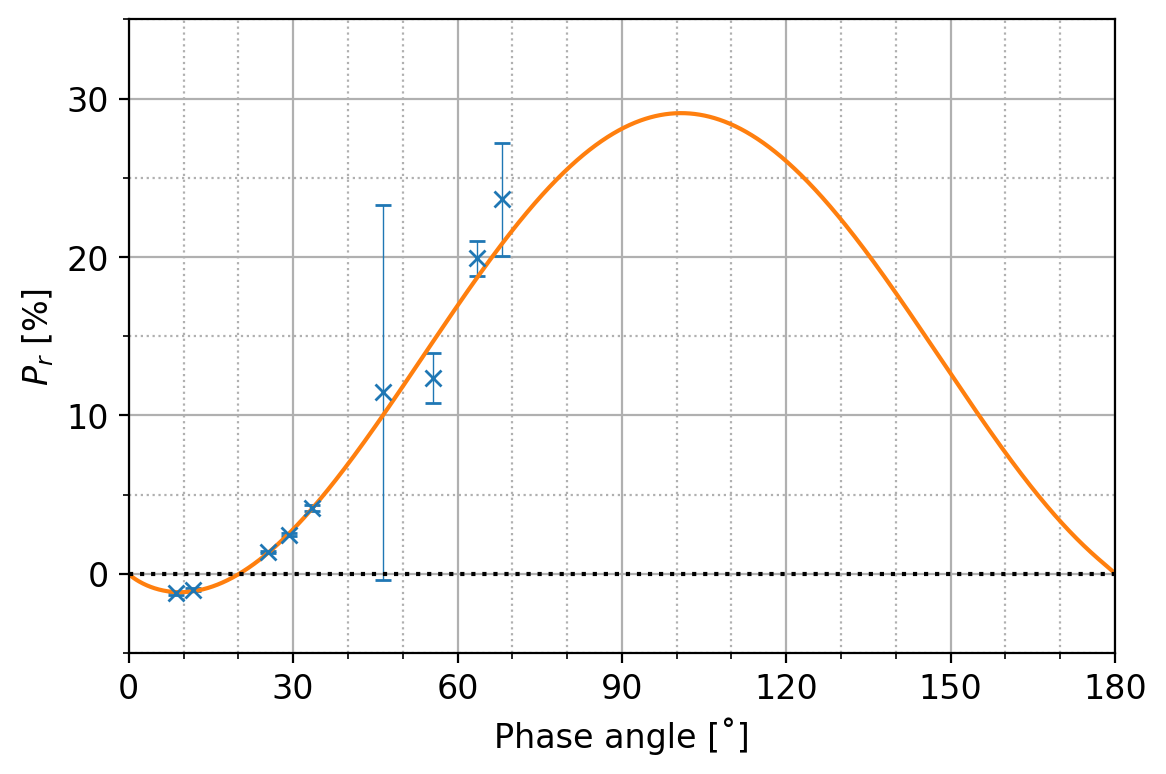

In [6]:
x, y, yerr = dats["PA"].to_numpy(), dats["Pr"].to_numpy(), dats["err_Pr"].to_numpy()
x_rad = D2R * x
xx = np.arange(0.1, 180, 0.1)

popt, pcov = curve_fit(trigp_purepython, x, y, sigma=yerr, p0=[1, 1, 1, 20],
                       absolute_sigma=True,
                       bounds=((0.01, 1.e-4, 1.e-4, 10),
                               (10.0, 10.0, 10.0, 30)))

fig, ax1 = plt.subplots(1, 1, figsize=(6, 4), sharex=False, sharey=False, gridspec_kw=None)

majloc = [MultipleLocator(30), MultipleLocator(10)]
minloc = [MultipleLocator(10), MultipleLocator(5)]
majfmt = [FormatStrFormatter("%d"), FormatStrFormatter("%d")]

ax1 = plt.subplot(1, 1, 1)
ax1.errorbar(x, y, yerr, **errbfmt)
ax1.plot(xx, trigp_purepython(xx, *popt))

ax1.set_xlabel("Phase angle [˚]")
ax1.set_ylabel(r"$ P_r $ [%]")
ax1.set_xlim(0, 180)
ax1.set_ylim(-5, 35)
ax1.axhline(0, color='k', ls=':')

for i, aa in enumerate([ax1.xaxis, ax1.yaxis]):
    aa.set_major_locator(majloc[i])
    aa.set_minor_locator(minloc[i])
    aa.set_major_formatter(majfmt[i])
ax1.grid(which='major', ls='-')
ax1.grid(which='minor', ls=':')
plt.tight_layout()

plt.savefig(SAVEPATH / "observation-fit.png")
plt.savefig(SAVEPATH / "observation-fit.pdf")

### 4-2. MCMC with ``pymc3``
Now that we got some clue about the initial parameters, do MCMC.

I assume all the parameters follow **uniform prior**, but only the lower/upper bounds of the parameters are subjectively set. 

**HERE I AM ASSUMING THE POWER PARAMETERS (C1 AND C2) ARE POSITIVE**. For non-bounded case, see section 5.

Run pymc3 for MCMC simulation:

In [7]:
basic_model = pm.Model()
with basic_model:
    h = pm.Uniform('h', 0, 1)
    a0 = pm.Uniform('a0', 10, 35)
    c1 = pm.Uniform('c1', 1.e-4, 3)
    c2 = pm.Uniform('c2', 1.e-4, 3)
#     c2 = pm.HalfNormal('c2', 0.1)

    sigma = theano.shared(np.asarray(yerr, dtype=theano.config.floatX), name='sigma')

    Y_hat = (h / D2R 
             * (sin(x * D2R) / sin(a0 * D2R))**c1 
             * (cos(x * D2R / 2) / cos(a0 * D2R / 2))**c2 
             * sin( (x - a0) * D2R)
            )
    liklihood = pm.Normal('likelihood', mu=Y_hat, sd=sigma, observed=y)

    trace = pm.sample(20000, start=dict(h=0.1, a0=20, c1=0.1, c2=1.e-3))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c2, c1, a0, h]
Sampling 4 chains, 0 divergences: 100%|██████████| 82000/82000 [00:36<00:00, 2231.54draws/s]
The acceptance probability does not match the target. It is 0.8910110625923814, but should be close to 0.8. Try to increase the number of tuning steps.


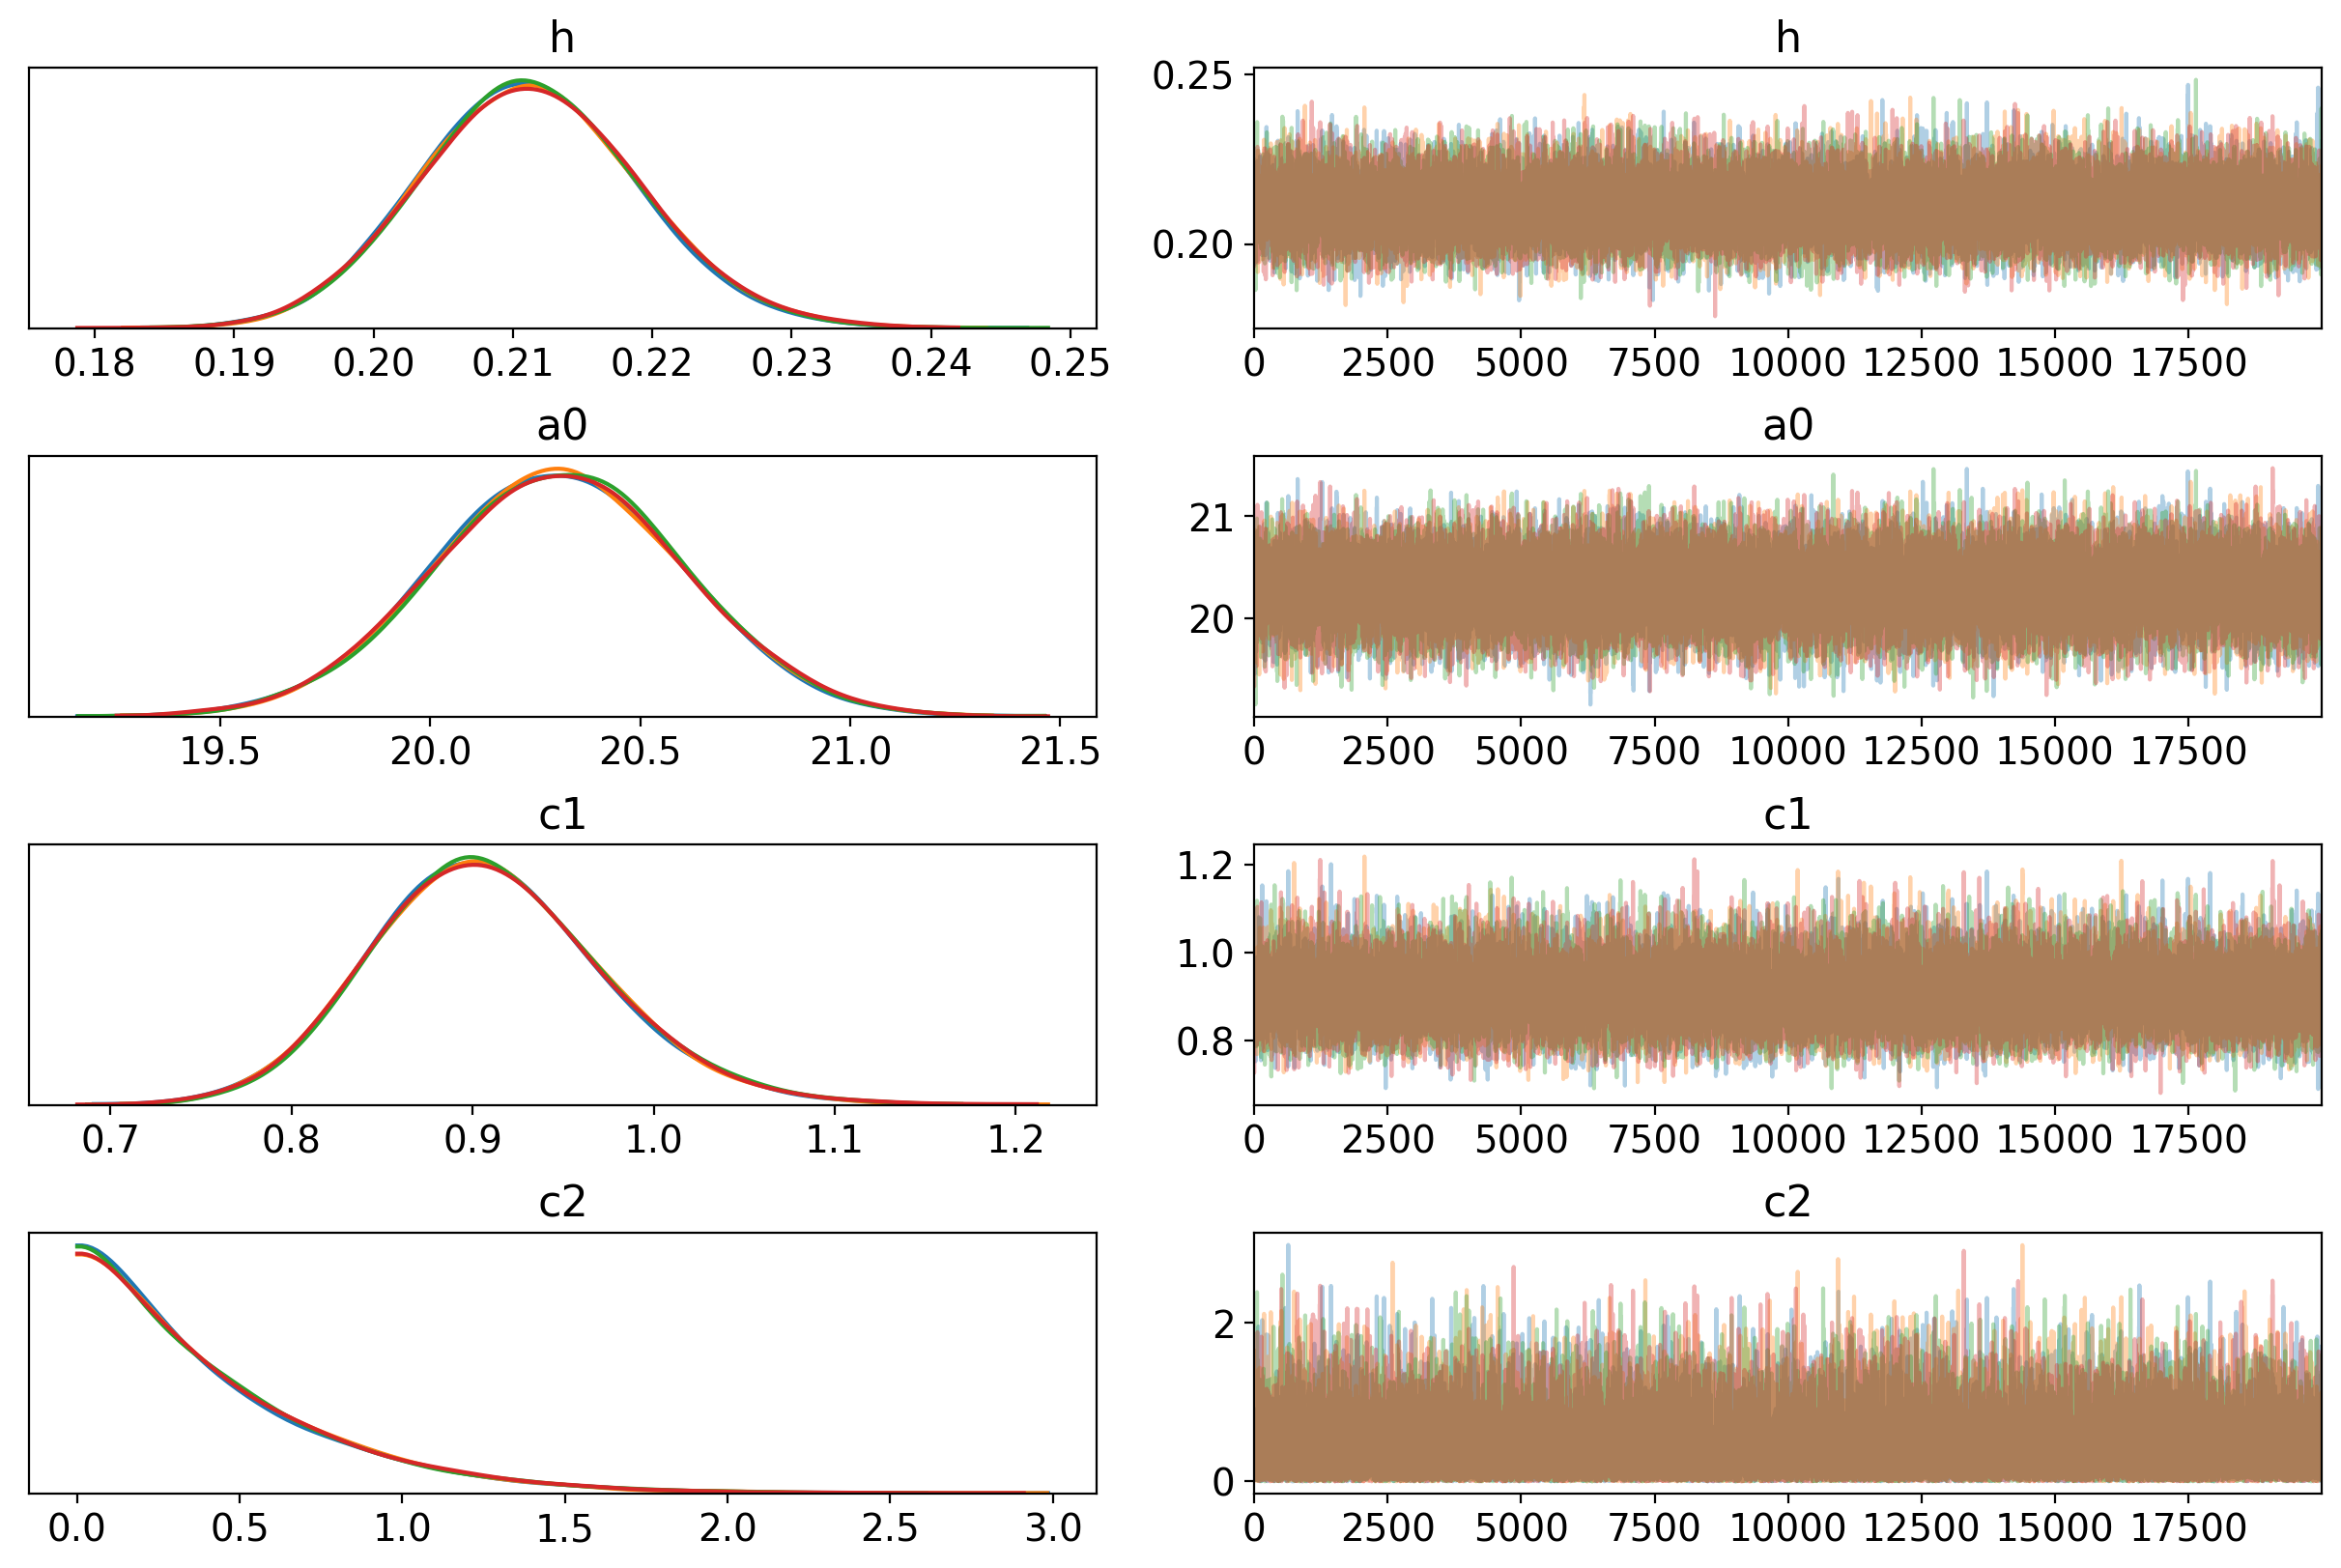

In [8]:
pm.traceplot(trace)
plt.savefig(SAVEPATH / "trace.png", dpi=300)
plt.savefig(SAVEPATH / "trace.pdf")

As can be seen, the trace looks very good except for c2. (see [here](https://support.sas.com/documentation/cdl/en/statug/63033/HTML/default/viewer.htm#statug_introbayes_sect008.htm#statug.introbayes.bayesvisual))

The trace plot shows the "trace" of the Monte Carlo traces of the parameter space. Below I show the hpd (Highest Posterior Density) intervals for 1- and 3-sigma level are shown. 

In Bayesian sense, the posterior mean and standard deviation are used as parameter estimation and estimation error (e.g., see [here](https://support.sas.com/documentation/cdl/en/statug/63033/HTML/default/viewer.htm#statug_introbayes_sect005.htm#statug.introbayes.bayesinterval)), while ``mc_error`` can be understood as an uncertainty intrinsic to this simulation due to the finite number of simulations (defined as ``sd/n_eff``). This should never be understood of the parameter uncertainty.

In [9]:
pm.summary(trace, credible_interval=0.6827).round(5)

mean     sd  hpd_15.865%  hpd_84.135%  mcse_mean  mcse_sd  ess_mean  \
h    0.211  0.008        0.203        0.218      0.000    0.000   28202.0   
a0  20.301  0.293       20.013       20.599      0.002    0.001   25055.0   
c1   0.908  0.063        0.840        0.963      0.000    0.000   28672.0   
c2   0.418  0.375        0.000        0.501      0.002    0.002   27550.0   

     ess_sd  ess_bulk  ess_tail  r_hat  
h   27969.0   28520.0   32962.0    1.0  
a0  24983.0   25058.0   31540.0    1.0  
c1  28058.0   29699.0   30241.0    1.0  
c2  27192.0   26552.0   29711.0    1.0

In summary, $ h = 0.211 \pm 0.008 \,[\%/^\circ] $ with $n_\mathrm{eff} \approx 34000$, etc, for $ \mathrm{mean \pm std} $ notation.

In [10]:
pm.summary(trace, credible_interval=0.9973).round(5)  # 3-sigma

mean     sd  hpd_0.135%  hpd_99.865%  mcse_mean  mcse_sd  ess_mean  \
h    0.211  0.008       0.189        0.236      0.000    0.000   28202.0   
a0  20.301  0.293      19.418       21.163      0.002    0.001   25055.0   
c1   0.908  0.063       0.732        1.122      0.000    0.000   28672.0   
c2   0.418  0.375       0.000        2.008      0.002    0.002   27550.0   

     ess_sd  ess_bulk  ess_tail  r_hat  
h   27969.0   28520.0   32962.0    1.0  
a0  24983.0   25058.0   31540.0    1.0  
c1  28058.0   29699.0   30241.0    1.0  
c2  27192.0   26552.0   29711.0    1.0

In [11]:
res = []
for h, a0, c1, c2 in zip(trace.get_values('h'),
                         trace.get_values('a0'),
                         trace.get_values('c1'),
                         trace.get_values('c2')):
    res.append(trigp_min(xx, h, c1, c2, a0))
res = np.array(res)
amin_mean, pmin_mean = np.mean(res, axis=0)
amin_sd, pmin_sd = np.std(res, axis=0, ddof=1)
print(f"a_min = {amin_mean:.4f} ± {amin_sd:.4f}")
print(f"P_min = {pmin_mean:.4f} ± {pmin_sd:.4f}")

a_min = 9.6436 ± 0.4310
P_min = -1.1632 ± 0.0617


### 4-3. Chi-Square Analysis
In the chi-square sense, what we have to do are
1. Calculate the chi-square statistic at each parameter space position. 
2. Keep only those with $\chi^2 < \chi^2_\mathrm{min} + \Delta(\nu, \alpha)$ 
    * $\Delta$: inverse cdf (cumulative distribution function) of $\chi^2$ distribution.
    * $\alpha$: significance level ($\alpha = 0.6827$ for 1-σ)
    * $\nu$: number of free parameters.
3. These are the models "within 1-sigma level confidence interval".
4. Get the min/max of each of the parameters and set these as lower/upper limit of the parameters.
5. The "center" of the parameters can be obtained by simple maximum likelihood estimation, such as least-square fitting.

Since it's difficult to sample all the 4-D paramter space, I used the traced parameter values from the MCMC above. 

Summarize for the models with 1-sigma chi-square value:

In [12]:
n_param = 4
delta = chi2.ppf(0.6827, n_param)

n_trace = trace['h'].shape[0]
res = dict(h=trace['h'], c1=trace['c1'], c2=trace['c2'], a0=trace['a0'],
           chi2=np.zeros(n_trace),
           amax=np.zeros(n_trace), amin=np.zeros(n_trace),
           Pmax=np.zeros(n_trace), Pmin=np.zeros(n_trace))

do_trigp(x, y, yerr, 
         arr_h=res["h"], arr_c1=res["c1"], arr_c2=res["c2"], arr_a0=res["a0"], 
         arr_chi2=res["chi2"],
         arr_amax=res["amax"], arr_Pmax=res["Pmax"], 
         arr_amin=res["amin"], arr_Pmin=res["Pmin"])

chi2_min = res["chi2"].min()
mask_1sig = res["chi2"] < (chi2_min + delta)
# mask_1sig = res["chi2"] < (chi2_min + np.sqrt(2/(y.shape[0]-4)))

res_df = pd.DataFrame(res)
res_1sig = res_df[mask_1sig]

res_1sig.describe()

h            c1            c2            a0          chi2  \
count  46569.000000  46569.000000  46569.000000  46569.000000  46569.000000   
mean       0.210058      0.891994      0.264899     20.259253     10.714263   
std        0.005560      0.043412      0.211052      0.214545      1.153635   
min        0.193739      0.761930      0.000104     19.607824      8.002112   
25%        0.206087      0.861076      0.093180     20.107725      9.807275   
50%        0.210154      0.892939      0.213796     20.265996     10.738656   
75%        0.214167      0.923634      0.391596     20.418911     11.675386   
max        0.223744      1.005492      1.046180     20.772831     12.721543   

               amax          amin          Pmax          Pmin  
count  46569.000000  46569.000000  46569.000000  46569.000000  
mean      96.573315      9.548660     27.117816     -1.165082  
std        3.083460      0.304645      1.745343      0.046833  
min       86.750000      8.590000     22.445213     -1.301464  
25%       94.500000      9.330000     25.892047     -1.198469  
50%       97.150000      9.560000     27.150707     -1.164612  
75%       99.160000      9.770000     28.375412     -1.130984  
max      101.290000     10.300000     32.171404     -1.039784

Only the rows of ``min`` and ``max`` are important (see below). Others are virtually meaningless.

Simple least-square fit will give the following best-fit parameters with the diagonal components as the variance of parameters when the $\chi^2$ contour are N-D ellipse:

In [13]:
popt, pcov = curve_fit(trigp_purepython, x, y, sigma=yerr, 
                       p0=[1, 1, 1, 20],
                       absolute_sigma=True,
                       bounds=((0.01, 1.e-4, 1.e-4, 10),
                               (10.0, 10.0, 10.0, 30)))

print("Least Square Fit with Scipy curve_fit\n")
print("h[%/˚]  c1      c2      a0[˚]")
print(f"{popt[0]:.4f}  {popt[1]:.4f}  {popt[2]:.4f}  {popt[3]:.4f}\n")

print("Elliptical Approximation Errors of above")
print("{:.4f}  {:.4f}  {:.4f}  {:.4f}\n".format(*np.sqrt(np.diag(pcov))))

amin, Pmin = trigp_min(np.arange(0, 20, 0.01), *popt)
amax, Pmax = trigp_max(np.arange(80, 130, 0.01), *popt)
print("amin[˚]  Pmin[%]  amax[˚]  Pmax[%]")
print(f"{amin:.2f}     {Pmin:.2f}    {amax:.2f} {Pmax:.2f}")

Least Square Fit with Scipy curve_fit

h[%/˚]  c1      c2      a0[˚]
0.2082  0.8647  0.0001  20.1849

Elliptical Approximation Errors of above
0.0107  0.1182  1.0195  0.4318

amin[˚]  Pmin[%]  amax[˚]  Pmax[%]
9.38     -1.17    100.81 29.08


Summarize:

In [14]:
param_tab = dict(pars=["h", "c1", "c2", "a0", "amin", "Pmin", "amax", "Pmax"],
                 lsqs=[*popt, amin, Pmin, amax, Pmax],  # least-square solution
                 plus=[], minus=[],  # mins/maxs in lsqs +/- sense
                 mins=[], maxs=[]    # min/max of 1-sigma range
                )
for i, p in enumerate(param_tab["pars"]):
    pmin = res_1sig[p].min()
    pmax = res_1sig[p].max()
    p_hi = abs(pmax - param_tab["lsqs"][i])
    p_lo = abs(param_tab["lsqs"][i] - pmin)
    
    param_tab["mins"].append(pmin)
    param_tab["maxs"].append(pmax)
    param_tab["plus"].append(p_hi)
    param_tab["minus"].append(p_lo)
    
param_tab = pd.DataFrame.from_dict(param_tab)
param_tab

pars        lsqs      plus      minus       mins        maxs
0     h    0.208217  0.015527   0.014478   0.193739    0.223744
1    c1    0.864720  0.140772   0.102789   0.761930    1.005492
2    c2    0.000100  1.046080   0.000004   0.000104    1.046180
3    a0   20.184946  0.587885   0.577122  19.607824   20.772831
4  amin    9.380000  0.920000   0.790000   8.590000   10.300000
5  Pmin   -1.169186  0.129402   0.132278  -1.301464   -1.039784
6  amax  100.810000  0.480000  14.060000  86.750000  101.290000
7  Pmax   29.084190  3.087214   6.638977  22.445213   32.171404

That is, for example, $h = 0.208 ^{+0.0155}_{-0.0145} \,[\%/^\circ] $ such that the min/max are 0.194 and 0.224. (the exact value may slightly change from time to time especially the error-bars, because it's basically random sampling of finite number of samples)

Comparing the above values with the previous table's ``min`` and ``max`` of each parameter, we now have the best fit parameter and uncertainty ranges in chi-square senses.

### 4-4. Some Selected Model Plots from MCMC
Among the 80000 samples (excluding the first 2000 as burn-in phase, so that, e.g., ``len(trace.get_values['h'])`` will be 80000 not 82000), I plotted the models at every 100 index interval as black dotted line below. They're not necessarily "good" models because they are nothing but "trace".

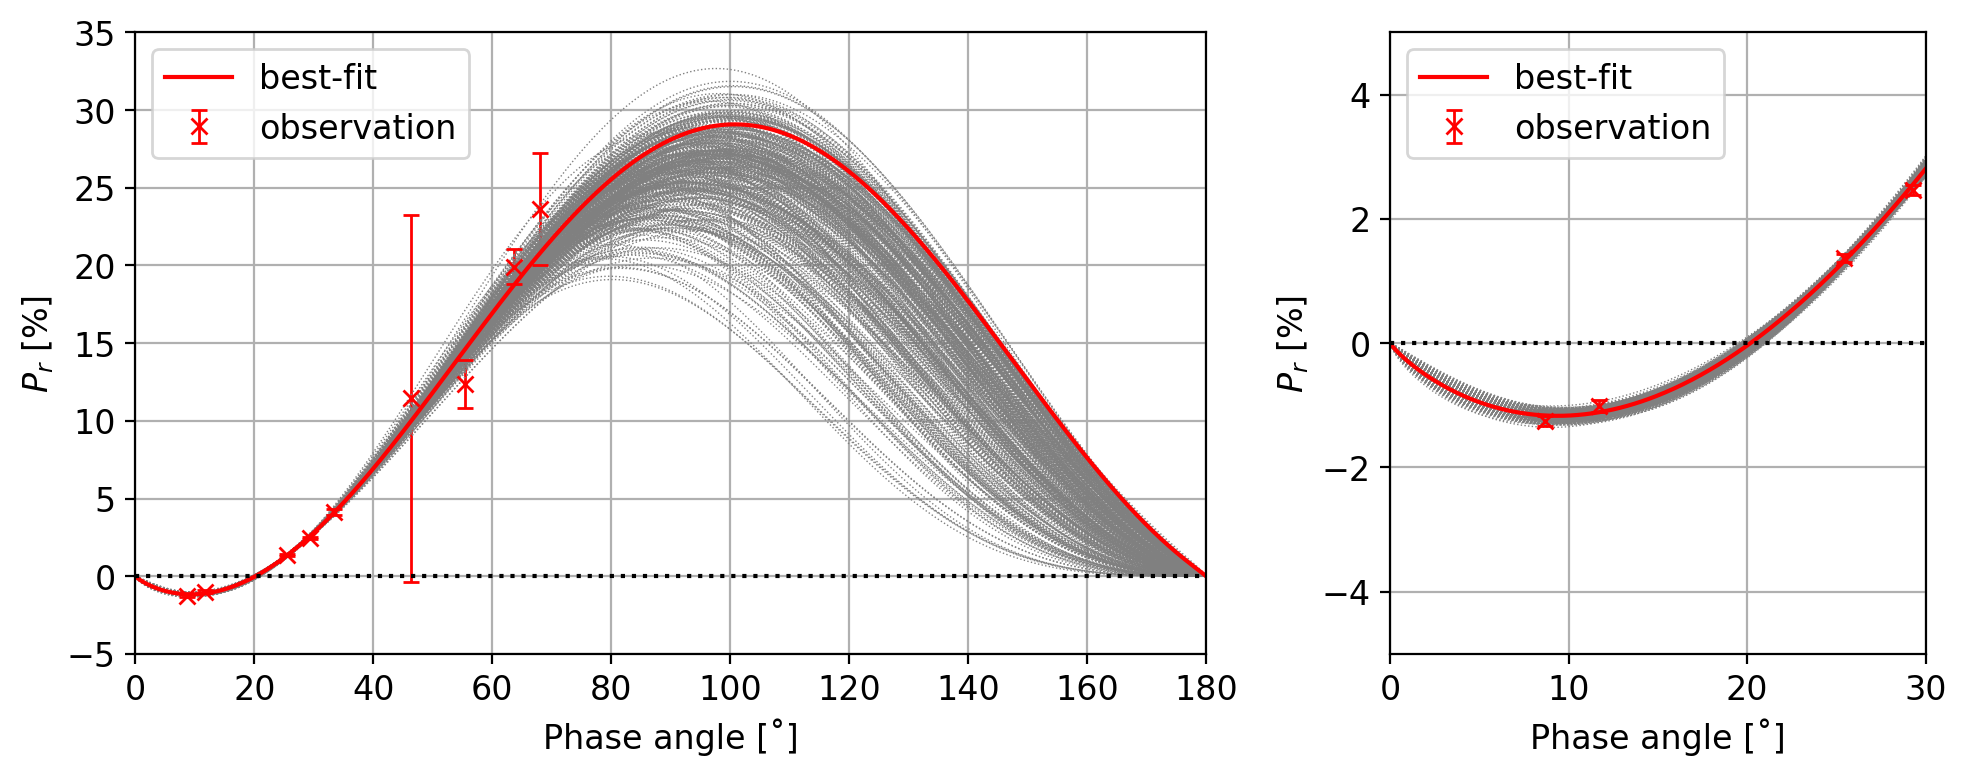

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=False, sharey=False, 
                        gridspec_kw={'width_ratios':[2,1]})

majloc = [MultipleLocator(30), MultipleLocator(10)]
minloc = [MultipleLocator(10), MultipleLocator(2)]
majfmt = [FormatStrFormatter("%d"), FormatStrFormatter("%d")]


for ax in axs.tolist():
    for j in range(0, n_trace, 200):
        ax.plot(xx, trigp_purepython(xx, res["h"][j], res["c1"][j], res["c2"][j], res["a0"][j]), 
                 ls=':', lw=0.5, color='grey')

    ax.errorbar(x, y, yerr, marker='x', elinewidth=1, capsize=3, color='r', ls='',
                label="observation")
    ax.plot(xx, trigp_purepython(xx, *popt), color='r', label="best-fit")

    ax.set_xlabel("Phase angle [˚]")
    ax.set_ylabel(r"$ P_r $ [%]")
    ax.legend(loc=2)
    ax.axhline(0, color='k', ls=':')

#     for i, aa in enumerate([ax.xaxis, ax.yaxis]):
#         aa.set_major_locator(majloc[i])
#         aa.set_minor_locator(minloc[i])
#         aa.set_major_formatter(majfmt[i])
    ax.grid(which='major', ls='-')
    ax.grid(which='minor', ls=':')

axs[0].set_xlim(0, 180)
axs[0].set_ylim(-5, 35)
axs[1].set_xlim(0, 30)
axs[1].set_ylim(-5, 5)



plt.tight_layout()
plt.savefig(SAVEPATH / "observation-mcmc.png", dpi=300)
plt.savefig(SAVEPATH / "observation-mcmc.pdf")

### 4-5. Pairplot of Parameters

Draw a corner plot

Text(0.5, 0.98, 'Median and 1-sigma percentiles')

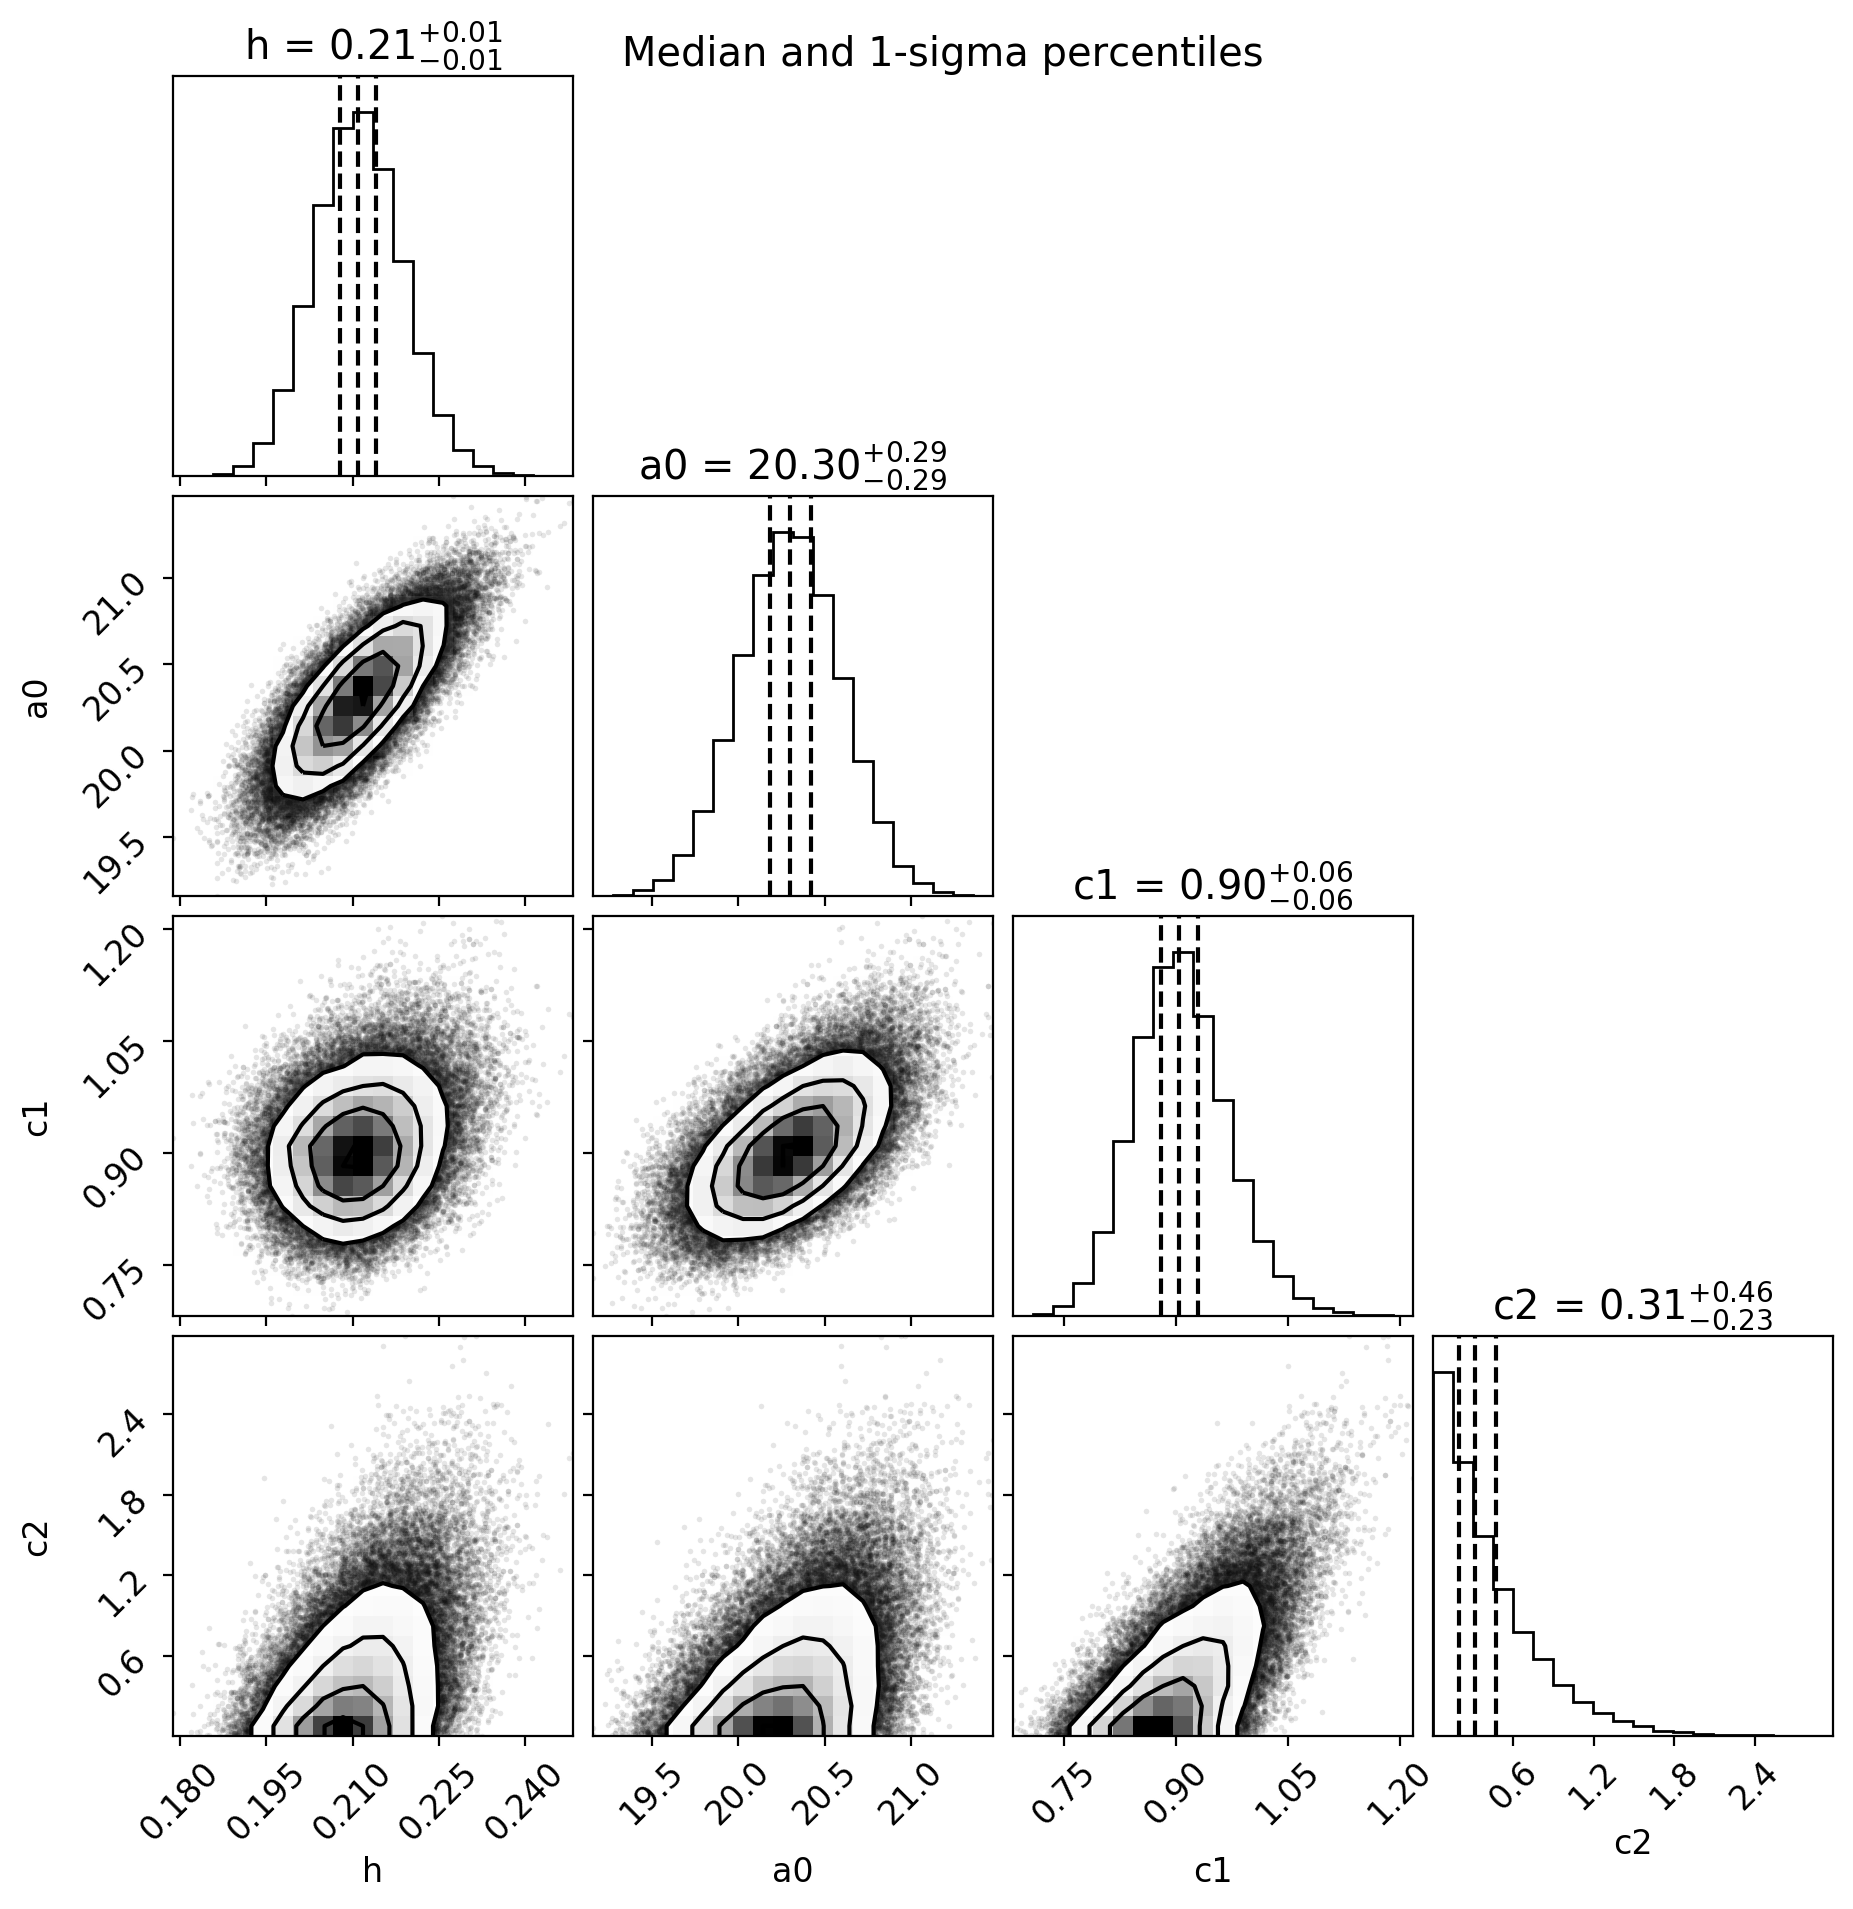

In [16]:
trace_df = pm.trace_to_dataframe(trace)
fig = corner.corner(trace_df, 
                    quantiles=[0.6827/2, 0.5, 1-0.6827/2],
                    show_titles=True)
fig.suptitle("Median and 1-sigma percentiles")

You may use ``seaborn`` which is extremely slow in this case:
```python
trace_df = pm.trace_to_dataframe(trace)
# sns.pairplot(,
#              kind='reg', markers='+')

g = sns.PairGrid(trace_df, diag_sharey=False)
g.map_lower(sns.kdeplot, kind='reg')
g.map_upper(sns.scatterplot)
g.map_diag(sns.kdeplot, lw=3)
```

### 4-6. To LATEX Table
If you want to save the resulting table as LaTeX format, for example, you may use the following python code:

In [17]:
from astropy.io.ascii.latex import latexdicts
from astropy.table import Table, vstack

tab = Table.from_pandas(param_tab)

for c in tab.colnames:
    try:    
        tab[c].format = '.4f'
    except ValueError:
        continue

tab.write(SAVEPATH / "test.tex", format='ascii.latex', latexdict=latexdicts["AA"])

``latexdicts["AA"]`` means it is in the format of A&A. You may use ``"AA"``, ``"doublelines"``, and ``"template"``.

It has the following output:

```latex
\begin{table}
\begin{tabular}{cccccc}
\hline \hline
pars & lsqs & plus & minus & mins & maxs \\
\hline
h & 0.2082 & 0.0178 & 0.0157 & 0.1925 & 0.2261 \\
c1 & 0.8647 & 0.1625 & 0.1120 & 0.7527 & 1.0273 \\
c2 & 0.0001 & 1.2607 & 0.0000 & 0.0001 & 1.2608 \\
a0 & 20.1849 & 0.6554 & 0.6485 & 19.5364 & 20.8404 \\
amin & 9.3800 & 1.0600 & 0.9000 & 8.4800 & 10.4400 \\
Pmin & -1.1692 & 0.1446 & 0.1485 & -1.3176 & -1.0246 \\
amax & 100.8100 & 0.5500 & 16.0500 & 84.7600 & 101.3600 \\
Pmax & 29.0842 & 3.4382 & 7.5246 & 21.5596 & 32.5224 \\
\hline
\end{tabular}
\end{table}
```

You may tune it as you wish...

## 5. What if no bound for powers?

In [18]:
basic_model = pm.Model()
with basic_model:
    h = pm.Uniform('h', 0, 1)
    a0 = pm.Uniform('a0', 10, 35)
    c1 = pm.Uniform('c1', -10, 10)
    c2 = pm.Uniform('c2', -10, 10)

    sigma = theano.shared(np.asarray(yerr, dtype=theano.config.floatX), name='sigma')

    Y_hat = (h / D2R 
             * (sin(x * D2R) / sin(a0 * D2R))**c1 
             * (cos(x * D2R / 2) / cos(a0 * D2R / 2))**c2 
             * sin( (x - a0) * D2R)
            )
    liklihood = pm.Normal('likelihood', mu=Y_hat, sd=sigma, observed=y)

    trace = pm.sample(20000, start=dict(h=0.1, a0=20, c1=0.1, c2=1.e-3))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c2, c1, a0, h]
Sampling 4 chains, 0 divergences: 100%|██████████| 82000/82000 [00:50<00:00, 1632.33draws/s]
The acceptance probability does not match the target. It is 0.8856455404126152, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


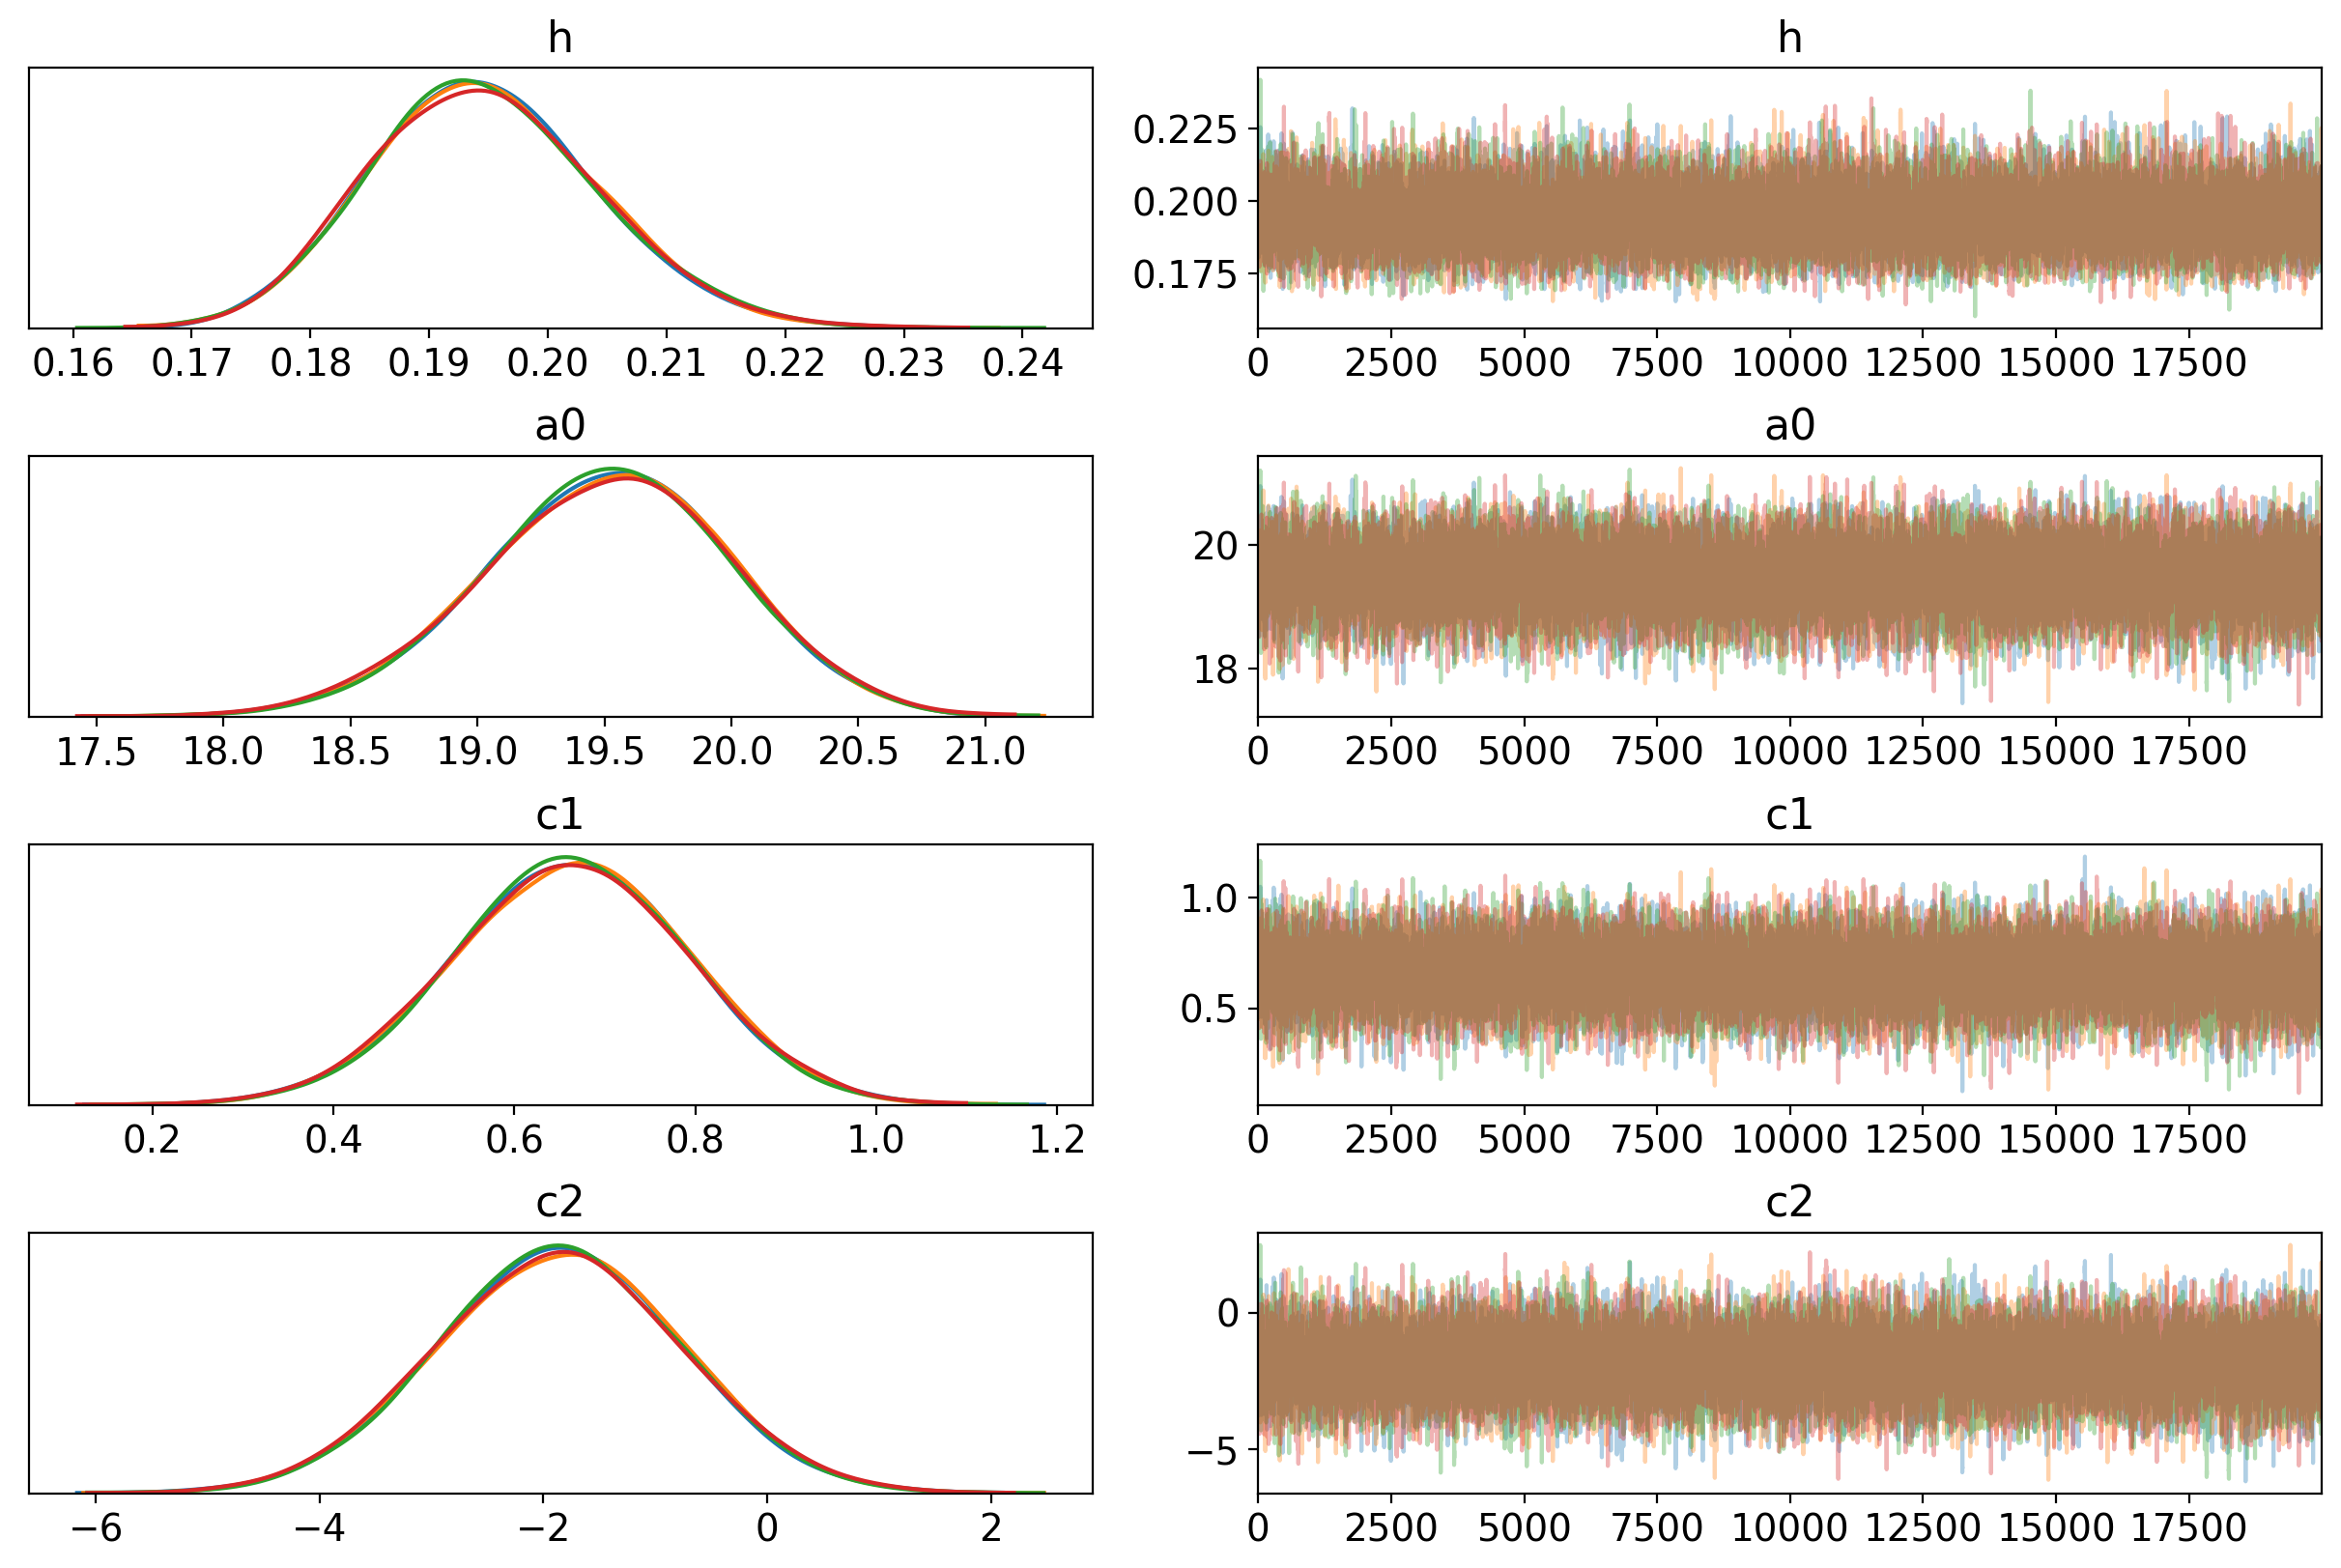

In [19]:
pm.traceplot(trace)
plt.savefig(SAVEPATH / "trace-nobound.png", dpi=300)
plt.savefig(SAVEPATH / "trace-nobound.pdf")

In [20]:
pm.summary(trace, credible_interval=0.6827).round(5)

mean     sd  hpd_15.865%  hpd_84.135%  mcse_mean  mcse_sd  ess_mean  \
h    0.195  0.009        0.184        0.203      0.000    0.000   17642.0   
a0  19.502  0.485       19.030       19.995      0.004    0.003   16225.0   
c1   0.659  0.129        0.532        0.789      0.001    0.001   16699.0   
c2  -1.880  1.070       -2.981       -0.834      0.008    0.006   16643.0   

     ess_sd  ess_bulk  ess_tail  r_hat  
h   17557.0   17785.0   23576.0    1.0  
a0  16214.0   16186.0   22146.0    1.0  
c1  16589.0   16688.0   21690.0    1.0  
c2  16643.0   16634.0   22406.0    1.0

In [21]:
pm.summary(trace, credible_interval=0.9973).round(5)  # 3-sigma

mean     sd  hpd_0.135%  hpd_99.865%  mcse_mean  mcse_sd  ess_mean  \
h    0.195  0.009       0.169        0.225      0.000    0.000   17642.0   
a0  19.502  0.485      17.924       20.812      0.004    0.003   16225.0   
c1   0.659  0.129       0.255        1.025      0.001    0.001   16699.0   
c2  -1.880  1.070      -5.056        1.307      0.008    0.006   16643.0   

     ess_sd  ess_bulk  ess_tail  r_hat  
h   17557.0   17785.0   23576.0    1.0  
a0  16214.0   16186.0   22146.0    1.0  
c1  16589.0   16688.0   21690.0    1.0  
c2  16643.0   16634.0   22406.0    1.0

In [22]:
res = []
for h, a0, c1, c2 in zip(trace.get_values('h'),
                         trace.get_values('a0'),
                         trace.get_values('c1'),
                         trace.get_values('c2')):
    res.append(trigp_min(xx, h, c1, c2, a0))
res = np.array(res)
amin_mean, pmin_mean = np.mean(res, axis=0)
amin_sd, pmin_sd = np.std(res, axis=0, ddof=1)
print(f"a_min = {amin_mean:.4f} ± {amin_sd:.4f}")
print(f"P_min = {pmin_mean:.4f} ± {pmin_sd:.4f}")

a_min = 7.7840 ± 1.0668
P_min = -1.2322 ± 0.0891


In [23]:
n_param = 4
delta = chi2.ppf(0.6827, n_param)

n_trace = trace['h'].shape[0]
res = dict(h=trace['h'], c1=trace['c1'], c2=trace['c2'], a0=trace['a0'],
           chi2=np.zeros(n_trace),
           amax=np.zeros(n_trace), amin=np.zeros(n_trace),
           Pmax=np.zeros(n_trace), Pmin=np.zeros(n_trace))

do_trigp(x, y, yerr, 
         arr_h=res["h"], arr_c1=res["c1"], arr_c2=res["c2"], arr_a0=res["a0"], 
         arr_chi2=res["chi2"],
         arr_amax=res["amax"], arr_Pmax=res["Pmax"], 
         arr_amin=res["amin"], arr_Pmin=res["Pmin"])

chi2_min = res["chi2"].min()
mask_1sig = res["chi2"] < (chi2_min + delta)
# mask_1sig = res["chi2"] < (chi2_min + np.sqrt(2/(y.shape[0]-4)))

res_df = pd.DataFrame(res)
res_1sig = res_df[mask_1sig]

res_1sig.describe()

h            c1            c2            a0          chi2  \
count  54160.000000  54160.000000  54160.000000  54160.000000  54160.000000   
mean       0.194391      0.657950     -1.893252     19.507480      7.091619   
std        0.007383      0.100609      0.838028      0.378442      1.201893   
min        0.175911      0.380988     -4.227617     18.432162      4.623715   
25%        0.188956      0.586075     -2.494304     19.239279      6.110370   
50%        0.194127      0.659337     -1.883103     19.517960      7.061062   
75%        0.199546      0.731339     -1.293338     19.784347      8.075383   
max        0.216042      0.920713      0.333964     20.479918      9.343266   

               amax          amin          Pmax          Pmin  
count  54160.000000  54160.000000  54160.000000  54160.000000  
mean     136.434544      7.804979    150.843815     -1.227611  
std        8.860072      0.827382    128.704182      0.066873  
min       95.310000      5.240000     26.272232     -1.452971  
25%      139.980000      7.240000     61.355739     -1.272801  
50%      139.980000      7.850000    108.300886     -1.223545  
75%      139.980000      8.420000    194.433629     -1.178196  
max      139.980000      9.780000   1022.765276     -1.066543

In [24]:
x, y, yerr = dats["PA"].to_numpy(), dats["Pr"].to_numpy(), dats["err_Pr"].to_numpy()
x_rad = D2R * x
xx = np.arange(0.1, 180, 0.1)

popt, pcov = curve_fit(trigp_purepython, x, y, sigma=yerr, 
                       p0=[1, 1, 1, 20],
                       absolute_sigma=True,
                       bounds=((0.01, -10., -10., 10),
                               (10.0, 10.0, 10.0, 30)))
print("Least Square Fit with Scipy curve_fit\n")
print("h[%/˚]  c1      c2      a0[˚]")
print(f"{popt[0]:.4f}  {popt[1]:.4f}  {popt[2]:.4f}  {popt[3]:.4f}\n")

print("Elliptical Approximation Errors of above")
print("{:.4f}  {:.4f}  {:.4f}  {:.4f}\n".format(*np.sqrt(np.diag(pcov))))

amin, Pmin = trigp_min(np.arange(0, 20, 0.01), *popt)
amax, Pmax = trigp_max(np.arange(80, 130, 0.01), *popt)
print("amin[˚]  Pmin[%]  amax[˚]  Pmax[%]")
print(f"{amin:.2f}     {Pmin:.2f}    {amax:.2f} {Pmax:.2f}")

Least Square Fit with Scipy curve_fit

h[%/˚]  c1      c2      a0[˚]
0.1942  0.6564  -1.9193  19.5151

Elliptical Approximation Errors of above
0.0092  0.1239  1.0342  0.4711

amin[˚]  Pmin[%]  amax[˚]  Pmax[%]
7.83     -1.22    129.98 91.26


In [25]:
param_tab = dict(pars=["h", "c1", "c2", "a0", "amin", "Pmin", "amax", "Pmax"],
                 lsqs=[*popt, amin, Pmin, amax, Pmax],  # least-square solution
                 plus=[], minus=[],  # mins/maxs in lsqs +/- sense
                 mins=[], maxs=[]    # min/max of 1-sigma range
                )
for i, p in enumerate(param_tab["pars"]):
    pmin = res_1sig[p].min()
    pmax = res_1sig[p].max()
    p_hi = abs(pmax - param_tab["lsqs"][i])
    p_lo = abs(param_tab["lsqs"][i] - pmin)
    
    param_tab["mins"].append(pmin)
    param_tab["maxs"].append(pmax)
    param_tab["plus"].append(p_hi)
    param_tab["minus"].append(p_lo)
    
param_tab = pd.DataFrame.from_dict(param_tab)
param_tab

pars        lsqs        plus      minus       mins         maxs
0     h    0.194197    0.021845   0.018286   0.175911     0.216042
1    c1    0.656409    0.264304   0.275421   0.380988     0.920713
2    c2   -1.919324    2.253288   2.308293  -4.227617     0.333964
3    a0   19.515136    0.964782   1.082974  18.432162    20.479918
4  amin    7.830000    1.950000   2.590000   5.240000     9.780000
5  Pmin   -1.221717    0.155174   0.231254  -1.452971    -1.066543
6  amax  129.980000   10.000000  34.670000  95.310000   139.980000
7  Pmax   91.260627  931.504648  64.988396  26.272232  1022.765276

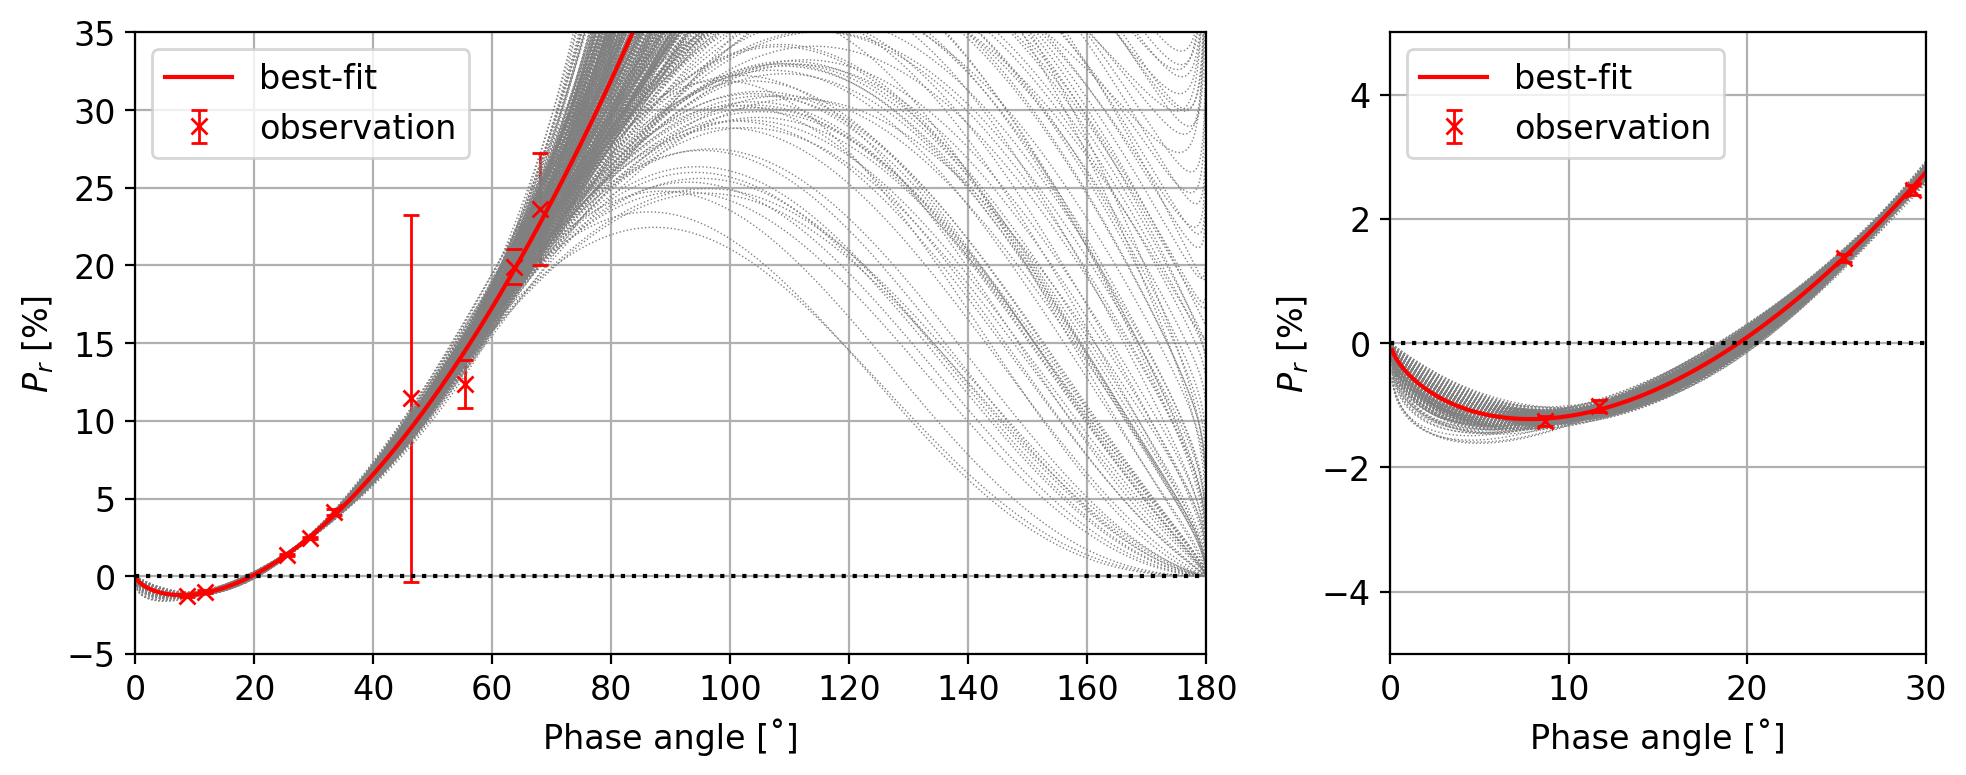

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=False, sharey=False, 
                        gridspec_kw={'width_ratios':[2,1]})

majloc = [MultipleLocator(30), MultipleLocator(10)]
minloc = [MultipleLocator(10), MultipleLocator(2)]
majfmt = [FormatStrFormatter("%d"), FormatStrFormatter("%d")]


for ax in axs.tolist():
    for j in range(0, n_trace, 200):
        ax.plot(xx, trigp_purepython(xx, res["h"][j], res["c1"][j], res["c2"][j], res["a0"][j]), 
                 ls=':', lw=0.5, color='grey')

    ax.errorbar(x, y, yerr, marker='x', elinewidth=1, capsize=3, color='r', ls='',
                label="observation")
    ax.plot(xx, trigp_purepython(xx, *popt), color='r', label="best-fit")

    ax.set_xlabel("Phase angle [˚]")
    ax.set_ylabel(r"$ P_r $ [%]")
    ax.legend(loc=2)
    ax.axhline(0, color='k', ls=':')

#     for i, aa in enumerate([ax.xaxis, ax.yaxis]):
#         aa.set_major_locator(majloc[i])
#         aa.set_minor_locator(minloc[i])
#         aa.set_major_formatter(majfmt[i])
    ax.grid(which='major', ls='-')
    ax.grid(which='minor', ls=':')

axs[0].set_xlim(0, 180)
axs[0].set_ylim(-5, 35)
axs[1].set_xlim(0, 30)
axs[1].set_ylim(-5, 5)



plt.tight_layout()
plt.savefig(SAVEPATH / "observation-mcmc-nobound.png", dpi=300)
plt.savefig(SAVEPATH / "observation-mcmc-nobound.pdf")

Text(0.5, 0.98, 'Median and 1-sigma percentiles')

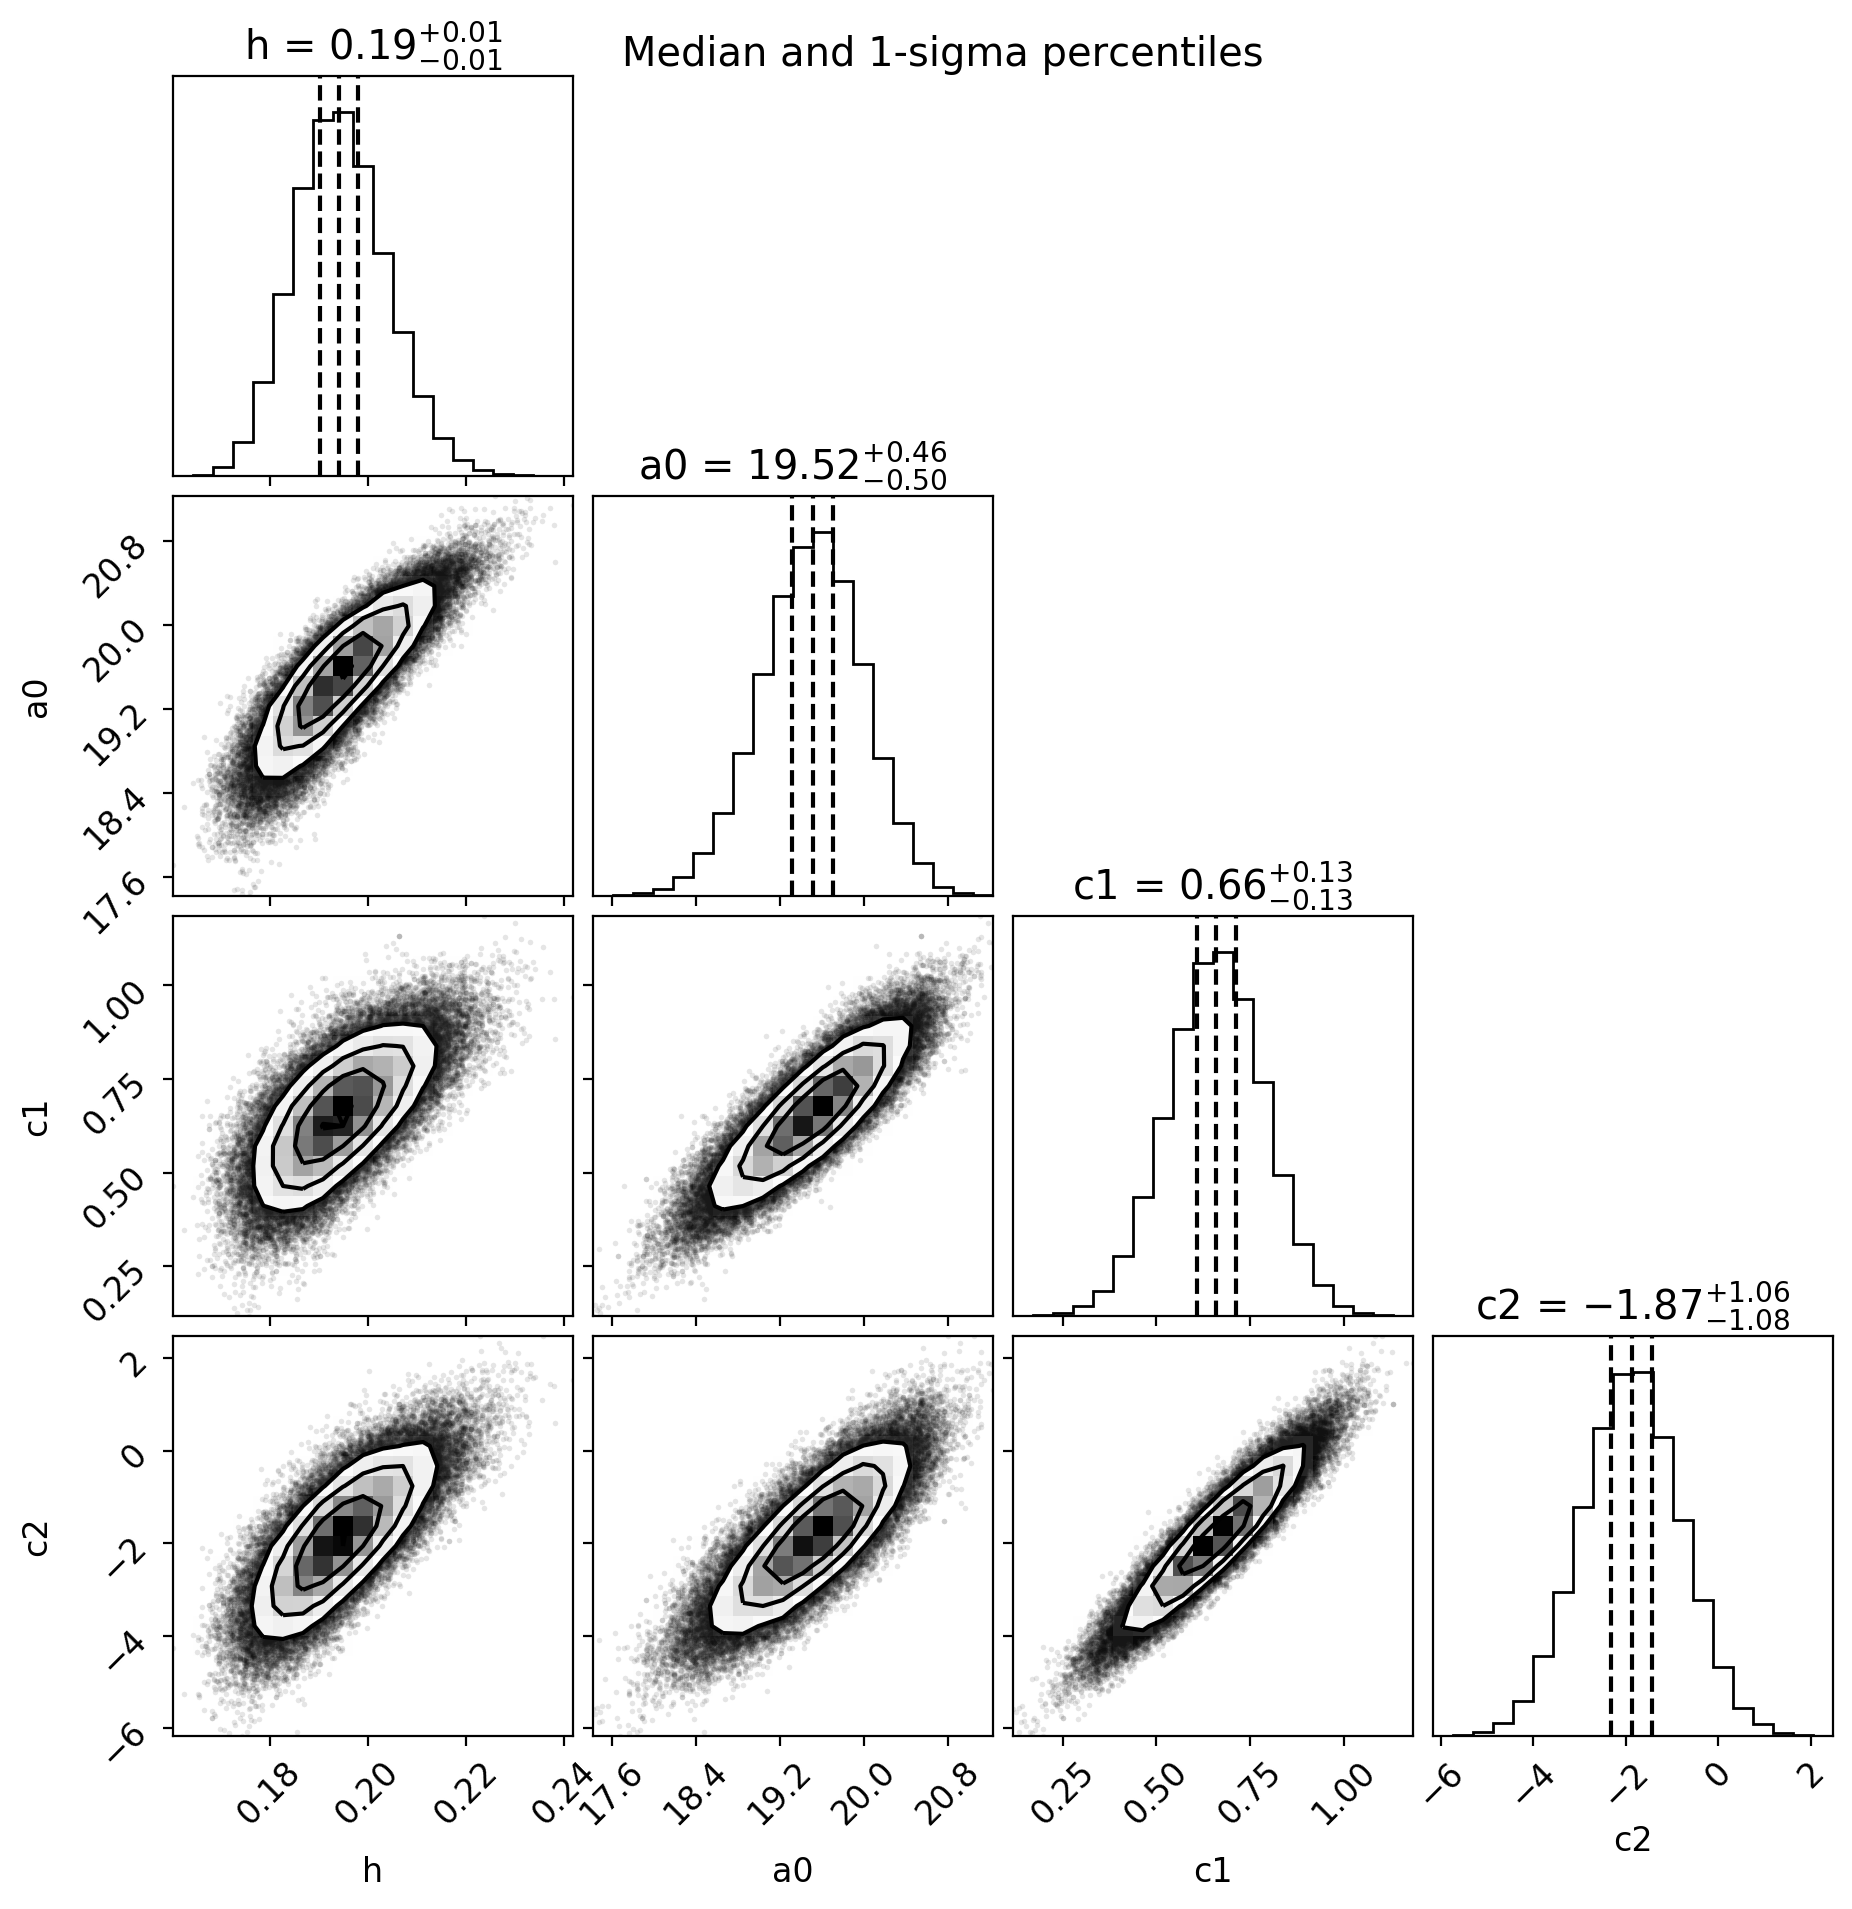

In [27]:
trace_df = pm.trace_to_dataframe(trace)
fig = corner.corner(trace_df, 
                    quantiles=[0.6827/2, 0.5, 1-0.6827/2],
                    show_titles=True)
fig.suptitle("Median and 1-sigma percentiles")

In [28]:
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was finished at {now} ")

This notebook was finished at 2020-02-14 17:11:02 (KST = GMT+0900) 
